<a href="https://colab.research.google.com/github/Doclikam/Project2_digital_health_app/blob/main/Notebooks/Copy_of_Iot_monitoring_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building a Mini Digital Health Dashboard**

# **Iot Health Monitoring Project**

# Load Data

In [305]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from warnings import filterwarnings
filterwarnings('ignore')
import joblib
from datetime import date
import datetime as dt
import hashlib
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
import requests
from scipy.stats import linregress
from datetime import timedelta
import os


In [306]:
os.makedirs("figures", exist_ok=True)

In [307]:
#load data
df_monitoring = pd.read_csv("/content/iot_health_monitoring_dataset.csv")
df_monitoring.head()

,timestamp,device_id,patient_id,heart_rate,blood_oxygen,blood_pressure_systolic,blood_pressure_diastolic,glucose_level,body_temperature,respiratory_rate,activity_level,sleep_quality,stress_level,hrv_sdnn,steps_count,calories_burned,health_event
0,2025-09-30 13:06:45.056387,DEVICE_0040,PATIENT_0310,88.7,91.9,178.0,100.0,131.1,97.66,23.3,0.486,0.215,0.778,12.7,2189,2033,3
1,2025-09-30 13:30:45.056387,DEVICE_0078,PATIENT_0147,82.3,96.5,122.0,82.0,57.7,98.89,19.9,0.650,0.671,0.296,58.1,11342,2634,0
2,2025-09-30 13:46:45.056387,DEVICE_0013,PATIENT_0129,101.7,91.3,139.0,102.0,143.4,98.89,26.5,0.490,0.395,0.772,17.2,3456,2157,3
3,2025-09-30 13:48:45.056387,DEVICE_0085,PATIENT_0470,73.9,98.3,121.0,88.0,108.5,98.73,16.5,0.445,0.707,0.339,97.2,8300,1631,0
4,2025-09-30 14:15:45.056387,DEVICE_0055,PATIENT_0245,75.7,93.0,109.0,81.0,109.2,98.74,14.2,0.612,0.844,0.197,64.1,7337,2498,0


In [308]:
#number of patients
df_monitoring.shape

(5094, 17)

## Data preprocessing

In [309]:
ID_COLS = ['device_id', 'patient_id']

VITAL_COLS = [
    'heart_rate',
    'blood_oxygen',
    'body_temperature',
    'respiratory_rate'
]

"""
these vital signs acan point to  anumber of health concerns, such as infections, hypoxia, shock, or cardiorespiratory conditions
we will asses if the abnomalities in these signs are transient or sustained(indicate disease pathology)
"""

CARDIO_METABOLIC_COLS = [
    'blood_pressure_systolic',
    'blood_pressure_diastolic',
    'glucose_level',
    'hrv_sdnn'
]
""" these can point to the existence of chronic conditions such as diabteds, hypertensiomn
they can alos alert us incase there is acute conditions such as shock, hyepertensive emergency
"""
BEHAVIORAL_COLS = [
    'activity_level',
    'sleep_quality',
    'stress_level'
]

CUMULATIVE_COLS = [
    'steps_count',
    'calories_burned'
]

EVENT_COLS = ['health_event']




In [310]:
#craete of copy of data
df_clean = df_monitoring.copy()

# Normalize column names
df_clean.columns = (
    df_clean.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

# Convert timestamps
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], errors='coerce')
df_clean = df_clean.sort_values('timestamp')

# Privacy: hash patient ID
df_clean['patient_id_hash'] = df_clean['patient_id'].astype(str).apply(
    lambda x: hashlib.sha256(x.encode()).hexdigest()
)
df_clean = df_clean.drop(columns=['patient_id'])

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5094 entries, 0 to 5093
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   timestamp                 5094 non-null   datetime64[ns]
 1   device_id                 5094 non-null   object        
 2   heart_rate                5094 non-null   float64       
 3   blood_oxygen              5094 non-null   float64       
 4   blood_pressure_systolic   5094 non-null   float64       
 5   blood_pressure_diastolic  5094 non-null   float64       
 6   glucose_level             5094 non-null   float64       
 7   body_temperature          5094 non-null   float64       
 8   respiratory_rate          5094 non-null   float64       
 9   activity_level            5094 non-null   float64       
 10  sleep_quality             5094 non-null   float64       
 11  stress_level              5094 non-null   float64       
 12  hrv_sdnn                 

In [311]:
df_clean = df_clean.set_index('timestamp')


In [312]:
df_clean.columns

Index(['device_id', 'heart_rate', 'blood_oxygen', 'blood_pressure_systolic',
       'blood_pressure_diastolic', 'glucose_level', 'body_temperature',
       'respiratory_rate', 'activity_level', 'sleep_quality', 'stress_level',
       'hrv_sdnn', 'steps_count', 'calories_burned', 'health_event',
       'patient_id_hash'],
      dtype='object')

In [313]:
# check for duplicates duplicates
df_monitoring.duplicated().sum()

np.int64(0)

In [314]:
#see the missing values
df_monitoring.isna().sum()

,0
timestamp,0
device_id,0
patient_id,0
heart_rate,0
blood_oxygen,0
blood_pressure_systolic,0
blood_pressure_diastolic,0
glucose_level,0
body_temperature,0
respiratory_rate,0


In [315]:
df_interp = df_clean.copy()

INTERPOLATE_COLS = [
    'heart_rate',
    'body_temperature',
    'respiratory_rate'
]

df_interp[INTERPOLATE_COLS] = (
    df_interp[INTERPOLATE_COLS]
    .interpolate(
        method='time',
        limit=2   # up to 10 minutes
    )
)
df_interp['hr_missing'] = df_clean['heart_rate'].isna()


In [316]:
df_interp['hr_count_30min'] = (
    df_interp['heart_rate']
    .notna()
    .rolling('30min')
    .sum()
)

df_interp['hr_reliable'] = df_interp['hr_count_30min'] >= 3

df_interp['hr_rolling_30min'] = (
    df_interp['heart_rate']
    .rolling('30min')
    .mean()
)

df_interp.loc[
    ~df_interp['hr_reliable'],
    'hr_rolling_30min'
] = np.nan



df_interp['spo2_rolling_30min'] = (
    df_interp['blood_oxygen']
    .rolling('30min')
    .mean()
)

df_interp.loc[
    ~df_interp['hr_reliable'],
    'spo2_rolling_30min'
] = np.nan


In [317]:
HR_HIGH = 120
HR_LOW = 50
SPO2_LOW = 92

df_interp['abnormal_hr'] = (df_interp['heart_rate'] > HR_HIGH) | (df_interp["heart_rate"]< HR_LOW)
df_interp['abnormal_spo2'] = df_interp['blood_oxygen'] < SPO2_LOW

df_interp['sustained_hr'] = (
    df_interp['abnormal_hr']
    .rolling('15min')
    .sum() >= 2
)

df_interp['sustained_spo2'] = (
    df_interp['abnormal_spo2']
    .rolling('15min')
    .sum() >= 2
)
#alert for active clinical abnormalities
df_interp['final_alert'] = (
    (
        (df_interp['sustained_hr'] & df_interp['abnormal_hr']) |
        (df_interp['sustained_spo2'] & df_interp['abnormal_spo2'])
    ) &
    df_interp['hr_reliable']
)




In [318]:
#flag patients with hypertension
df_interp['hypertensive'] = (
    (df_interp['blood_pressure_systolic'] >= 140) |
    (df_interp['blood_pressure_diastolic'] >= 90)
)
#flag patient with hpotension bp
df_interp['hyportensive'] = (
    (df_interp['blood_pressure_systolic'] <= 90) |
    (df_interp['blood_pressure_diastolic'] <= 60)
)
#flag patients with a veryu high(hyoperglycemia) or low glucose(hypoglycemia))
df_interp['hyperglycemia'] = df_interp['glucose_level'] >= 126
df_interp['hypoglycemia'] = df_interp['glucose_level'] <= 70

#flag p[ateint with a low herat rate variability that is belkow 30s
df_interp['low_hrv'] = df_interp['hrv_sdnn'] < 30


In [319]:
#let's get activity adjutsed heart rate, is oit incraesing or decreasing
df_interp["hr_expected_activity"] = (df_interp["heart_rate"]>100) & (df_interp["activity_level"]>0.6)
#flag patients with poor sleep
df_interp['poor_sleep'] = df_interp['sleep_quality'] < 0.3
# pfalg patients with high stress
df_interp['high_stress'] = df_interp['stress_level'] > 0.7



#  📊 Health Monitoring Dashboard


**Data Reliability & Monitoring Quality**

In [320]:
total_windows = len(df_interp)
reliable_pct = df_interp['hr_reliable'].mean() * 100
alert_rate = df_interp['final_alert'].mean() * 100

print(f"Reliable monitoring windows: {reliable_pct:.1f}%")
print(f"Alert rate: {alert_rate:.2f}% of time")


Reliable monitoring windows: 86.3%
Alert rate: 0.67% of time


**## 🫀 Heart Rate Trends**


In [356]:
#heart measuremenbt density
fig = px.line(df_interp.reset_index(), x ="timestamp", y ="hr_count_30min",
              title="Heart Rate Measurement Density (30-minute Window)",
              labels = {"timestamp": "Time",
                        "hr_count_30min": "Number of HR measurements"
                        })
#realiability threshshold
fig.add_hline(y=3,
              line_dash = "dash",
              line_color = "red",
              annotation_text = "Reliability threshhold (=>3)")

fig.update_traces(
    hovertemplate=
    "<b>Time</b>: %{x}<br>" +
    "<b>HR count (30 min)</b>: %{y}<br>" +
    "<extra></extra>"
)

fig.update_layout(
    height=350,
    hovermode="x unified"
)

fig.show()

In [355]:
#noow we visualize the relaible and unrelaible heart rate counts in 30 inutes
fig = px.scatter(
    df_interp.reset_index(),
    x='timestamp',
    y='hr_count_30min',
    color='hr_reliable',
    title="Heart Rate Measurement Density (Reliability-Relaible)",
    labels={
        'hr_count_30min': 'HR measurements in last 30 minutes',
        'hr_reliable': 'Data reliable'
    },
    color_discrete_map={True: 'green', False: 'red'}
)

fig.add_hline(
    y=3,
    line_dash="dash",
    line_color="black",
    annotation_text="Reliability threshold"
)

fig.update_traces(
    marker=dict(size=6),
    hovertemplate=
    "<b>Time</b>: %{x}<br>" +
    "<b>HR count</b>: %{y}<br>" +
    "<b>Reliable</b>: %{marker.color}<extra></extra>"
)

fig.update_layout(
    height=350,
    hovermode="x unified"
)

fig.show()


Health Events Overlaid on HR

In [357]:
fig = px.scatter(
    df_interp.reset_index(),
    x='timestamp',
    y='heart_rate',
    color='health_event',
    title="Heart Rate with Health Events Highlighted"
)

fig.update_layout(height=350)


fig.show()


**# SPO2 trends**

In [358]:
fig = px.line(
    df_interp.reset_index(),
    x='timestamp',
    y='blood_oxygen',
    title="Blood Oxygen Saturation (SpO₂)"
)

fig.add_hline(
    y=92,
    line_dash="dash",
    line_color="red",
    annotation_text="Hypoxia threshold"
)

fig.update_layout(height=300, hovermode="x unified")
fig.show()


In [359]:
#visualize the rolling trend
fig = px.line(
    df_interp.reset_index(),
    x='timestamp',
    y='hr_rolling_30min',
    title="30-minute Rolling Heart Rate (Reliability-Gated)",
    labels={'hr_rolling_30min': 'Heart Rate (bpm)'}
)

fig.update_traces(
    hovertemplate=
    "<b>Time</b>: %{x}<br>" +
    "<b>Rolling HR</b>: %{y:.1f} bpm<br>" +
    "<extra></extra>"
)

fig.update_layout(
    height=400,
    hovermode="x unified"
)

fig.show()


In [360]:
fig = px.line(
    df_interp.reset_index(),
    x='timestamp',
    y=['heart_rate', 'hr_rolling_30min'],
    title="Heart Rate: Raw Signal vs 30-minute Rolling Trend",
    labels={'value': 'Heart Rate (bpm)', 'variable': 'Signal'}
)

fig.update_layout(height=350, hovermode="x unified")

fig.show()


**# Cardio - metabolic Health Risks**

**Blood pressure**

In [327]:
#systolic blood pressure disribution
fig = px.histogram(
    df_interp,
    x='blood_pressure_systolic',
    nbins=40,
    title="Blood Pressure Distribution with Thresholds",
    labels={"Blood pressure": "BP (mmHg)"}
)

# Hypoglycemia threshold
fig.add_vline(
    x=60,
    line_dash="dash",
    line_color="blue",
    annotation_text="Diastolic (<60 mmHg)",
    annotation_position="top left"
)

# Hyperglycemia / diabetes threshold
fig.add_vline(
    x=140,
    line_dash="dash",
    line_color="red",
    annotation_text="Systolic (140 mmHg)",
    annotation_position="top right"
)

fig.update_layout(
    height=350,
    bargap=0.05
)

fig.show()

In [328]:
fig = px.line(
    df_interp.reset_index(),
    x="timestamp",
    y="blood_pressure_systolic",
    title="Systolic Blood Pressure Over Time",
    labels={"blood_pressure_systolic": "Systolic BP (mmHg)"}
)

fig.add_hline(y=90, line_dash="dash", line_color="blue",
              annotation_text="Hypotension")
fig.add_hline(y=140, line_dash="dash", line_color="red",
              annotation_text="Hypertension")

fig.update_layout(height=350, hovermode="x unified")

fig.show()


**Glucose Level**

In [329]:
df_interp['glucose_state'] = "Normal"

df_interp.loc[df_interp['glucose_level'] < 70, 'glucose_state'] = "Hypoglycemia"
df_interp.loc[df_interp['glucose_level'] >= 126, 'glucose_state'] = "Hyperglycemia"
fig = px.histogram(
    df_interp,
    x="glucose_level",
    color="glucose_state",
    nbins=40,
    opacity=0.6,
    title="Glucose Level Distribution by Clinical State",
    labels={"glucose_level": "Glucose (mg/dL)"}
)

fig.update_layout(
    height=400,
    barmode="overlay"
)

fig.show()


**# Behavioral and Lifestyle**

**Activity Level**

In [365]:
#heart rate vs activity level
fig = px.scatter(
    df_interp,
    x='activity_level',
    y='heart_rate',
    color='final_alert',
    title="Heart Rate vs Activity Level",
    labels={'activity_level': 'Activity level', 'final_alert': 'Alert'}
)

fig.update_layout(height=350)

fig.show()


**Sleep Quality & HRV index**

In [364]:
fig = px.scatter(
    df_interp,
    x='sleep_quality',
    y='hrv_sdnn',
    title="Sleep Quality vs HRV (Autonomic Recovery)"
)

fig.update_layout(height=300)

fig.show()


The patient with poor sleep quality also have a low hrv-sdnn

**Blood pressure vs stress**

In [363]:
fig = px.scatter(
    df_interp,
    x="stress_level",
    y="blood_pressure_systolic",
    color="health_event",
    title="Stress Level vs Systolic BP"
)

fig.show()


**Health Events**

Compare distribution across Health Events

health_event: Health event classification
0: Normal (4,330 samples - 85.0%)
1: Cardiac Arrhythmia (306 samples - 6.0%)
2: Hypoglycemia (267 samples - 5.2%)
3: Hypertension Crisis (191 samples - 3.8%)

In [333]:
#health events
df_interp["health_event"].value_counts(normalize=True) * 100


,proportion
health_event,
0,85.001963
1,6.007067
2,5.241461
3,3.749509


In [334]:
#map events
event_map = {
    0: "Normal",
    1: "Arrhythmia",
    2: "Hypoglycemia",
    3: "Hypertension Crisis"
}

df_interp["health_event_label"] = df_interp["health_event"].map(event_map)


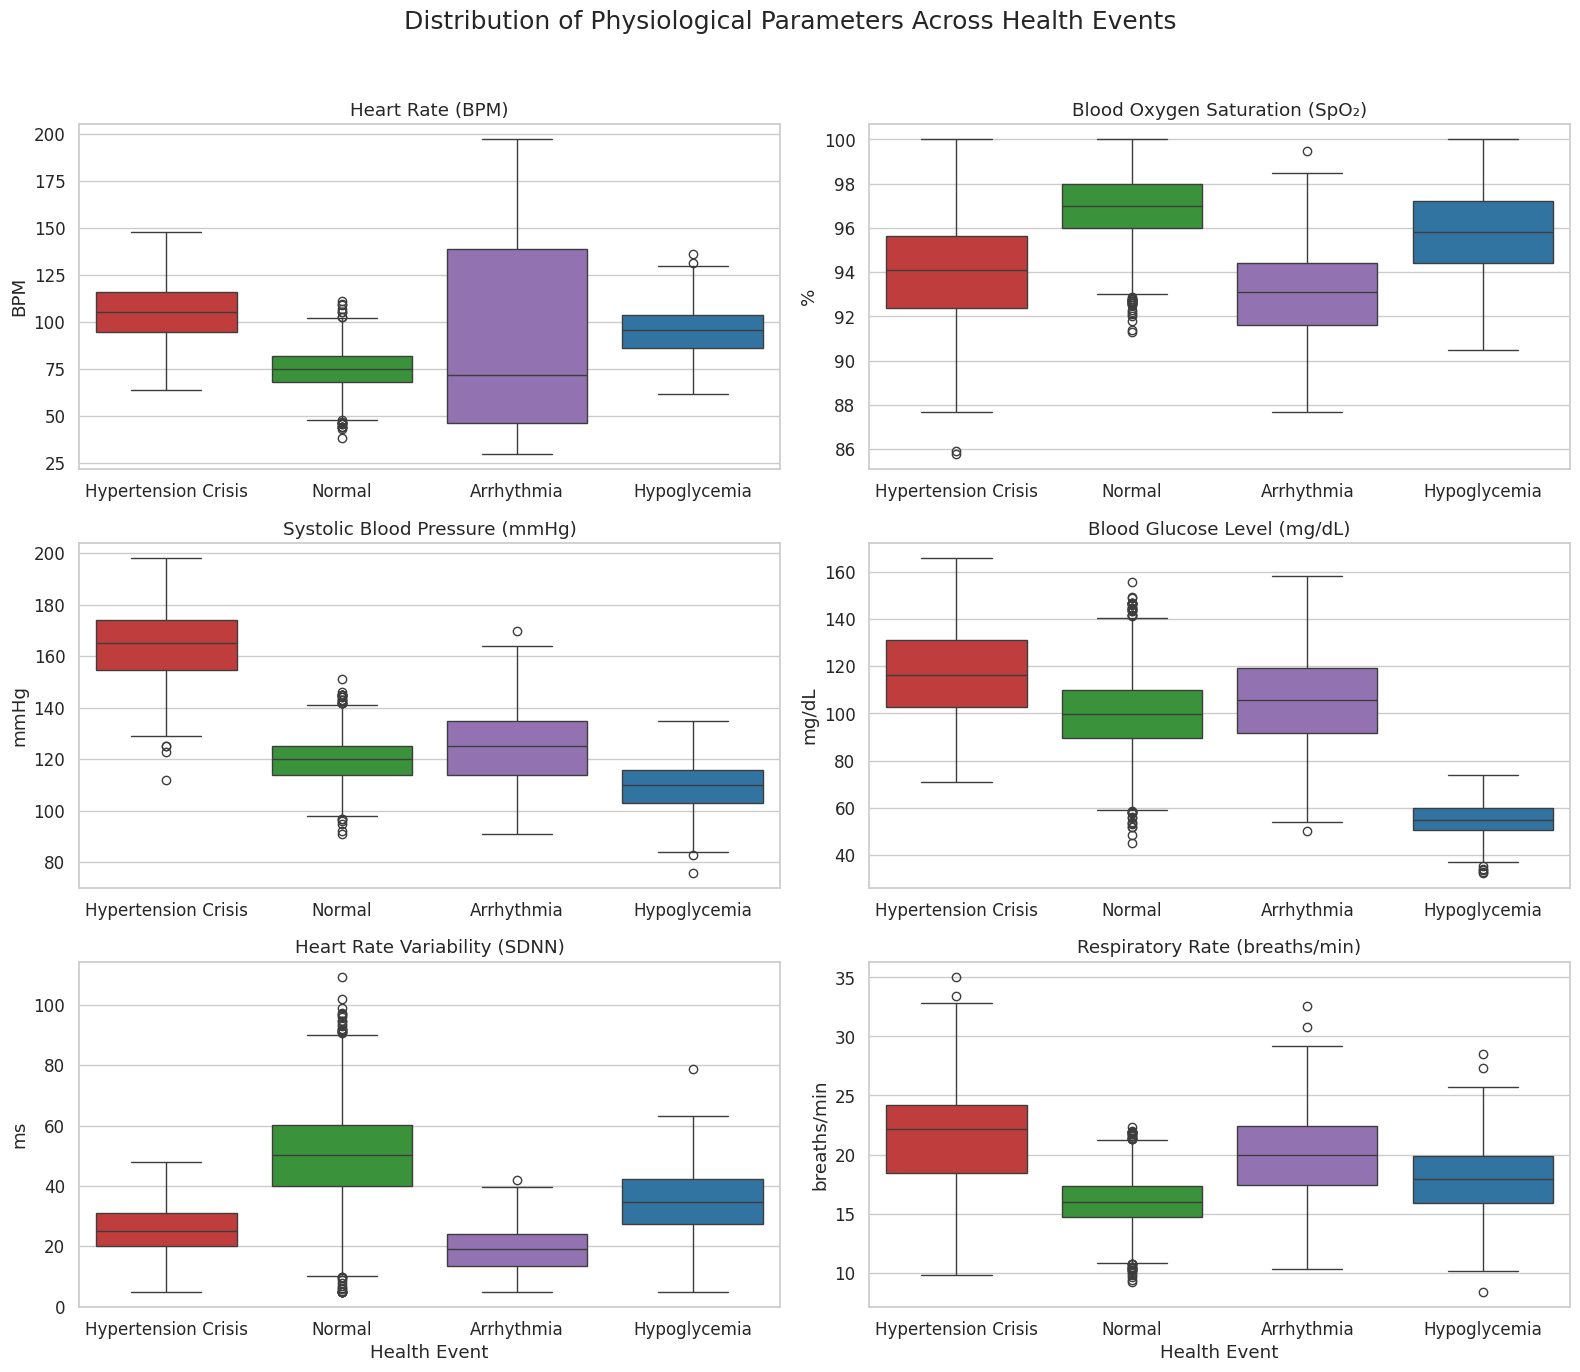

In [335]:

# Color palette (clinically intuitive)
event_palette = {
    "Normal": "#2ca02c",                 # green
    "Arrhythmia": "#9467bd",             # purple
    "Hypoglycemia": "#1f77b4",            # blue
    "Hypertension Crisis": "#d62728"     # red
}

sns.set(style="whitegrid", font_scale=1.1)

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle(
    "Distribution of Physiological Parameters Across Health Events",
    fontsize=18,
    y=0.98
)


# Heart Rate
sns.boxplot(
    ax=axes[0, 0],
    data=df_interp,
    x="health_event_label",
    y="heart_rate",
    palette=event_palette
)
axes[0, 0].set_title("Heart Rate (BPM)")
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("BPM")

# SpO2
sns.boxplot(
    ax=axes[0, 1],
    data=df_interp,
    x="health_event_label",
    y="blood_oxygen",
    palette=event_palette
)
axes[0, 1].set_title("Blood Oxygen Saturation (SpO₂)")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("%")


# Systolic Blood Pressure
sns.boxplot(
    ax=axes[1, 0],
    data=df_interp,
    x="health_event_label",
    y="blood_pressure_systolic",
    palette=event_palette
)
axes[1, 0].set_title("Systolic Blood Pressure (mmHg)")
axes[1, 0].set_xlabel("")
axes[1, 0].set_ylabel("mmHg")

# Glucose Level
sns.boxplot(
    ax=axes[1, 1],
    data=df_interp,
    x="health_event_label",
    y="glucose_level",
    palette=event_palette
)
axes[1, 1].set_title("Blood Glucose Level (mg/dL)")
axes[1, 1].set_xlabel("")
axes[1, 1].set_ylabel("mg/dL")

#HRV SDNN
sns.boxplot(
    ax=axes[2, 0],
    data=df_interp,
    x="health_event_label",
    y="hrv_sdnn",
    palette=event_palette
)
axes[2, 0].set_title("Heart Rate Variability (SDNN)")
axes[2, 0].set_xlabel("Health Event")
axes[2, 0].set_ylabel("ms")

# Respiratory Rate
sns.boxplot(
    ax=axes[2, 1],
    data=df_interp,
    x="health_event_label",
    y="respiratory_rate",
    palette=event_palette
)
axes[2, 1].set_title("Respiratory Rate (breaths/min)")
axes[2, 1].set_xlabel("Health Event")
axes[2, 1].set_ylabel("breaths/min")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("figures/Distribution of Physiological Parameters Across Health Events")
plt.show()


In arrythmias heart rate is irregular and heart rate variability is low.

In [367]:
#plot hrv variability SDNN and HR by event
fig = px.scatter(
    df_interp,
    x="heart_rate",
    y="hrv_sdnn",
    color="health_event",
    title="Heart Rate vs HRV Across Health Events"
)

fig.show()


## 🚨 Alert Monitoring


Clinicians need to monitor early signs of detrioriation including cardiac arrythmias, hypertensive emergencies  and glycemic crises. Conditions like sepsis which can predispose to life threatenimng cardiac arrythmias can be monitored and detected early based on the heart rate, bp, temperature, respiartory rate

In [337]:
#sepsis risk score
def sepsis_score(row):
    score = 0
    reasons = []

    if row["heart_rate"] > 100:
        score += 1
        reasons.append("Tachycardia")

    if row["respiratory_rate"] > 22:
        score += 1
        reasons.append("Tachypnea")

    if row["body_temperature"] > 100.4:
        score += 1
        reasons.append("Fever")

    if row.get("hr_anomaly") == -1:
        score += 1
        reasons.append("HR anomaly")

    return score, reasons
#apply stratification
df_interp[["sepsis_score", "sepsis_reasons"]] = df_interp.apply(
    lambda r: pd.Series(sepsis_score(r)),
    axis=1
)
#startify risk scores
def stratify(score):
    if score >= 3:
        return "HIGH"
    elif score == 2:
        return "MEDIUM"
    elif score == 1:
        return "LOW"
    else:
        return "NONE"

df_interp["sepsis_severity"] = df_interp["sepsis_score"].apply(stratify)



In [338]:
fig = px.scatter(
    df_interp.reset_index(),
    x='hr_count_30min',
    y='heart_rate',
    color='final_alert',
    title="Heart Rate vs Measurement Density",
    labels={
        'hr_count_30min': 'HR measurements in last 30 minutes',
        'heart_rate': 'Heart Rate (bpm)',
        'final_alert': 'Alert triggered'
    },
    color_discrete_map={True: 'red', False: 'blue'}
)

fig.update_traces(
    hovertemplate=
    "<b>Time</b>: %{customdata[0]}<br>" +
    "<b>HR</b>: %{y} bpm<br>" +
    "<b>HR count</b>: %{x}<br>" +
    "<extra></extra>",
    customdata=df_interp.reset_index()[['timestamp']]
)

fig.update_layout(height=400)

fig.show()


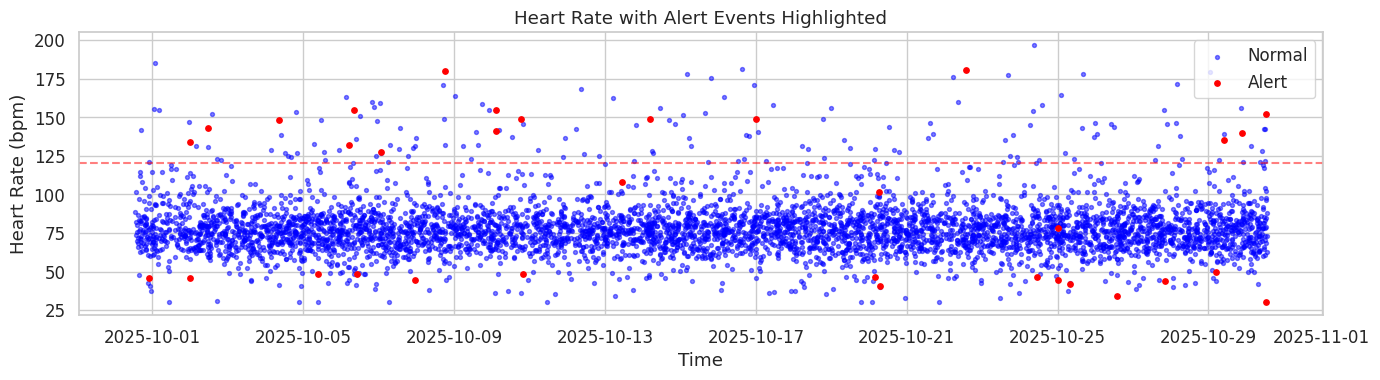

In [339]:
plt.figure(figsize=(14, 4))

# Normal HR points
normal = df_interp[~df_interp['final_alert']]
alerted = df_interp[df_interp['final_alert']]

plt.scatter(
    normal.index,
    normal['heart_rate'],
    color='blue',
    s=8,
    alpha=0.5,
    label='Normal'
)

plt.scatter(
    alerted.index,
    alerted['heart_rate'],
    color='red',
    s=15,
    label='Alert'
)

plt.axhline(120, color='red', linestyle='--', alpha=0.5)

plt.title("Heart Rate with Alert Events Highlighted")
plt.ylabel("Heart Rate (bpm)")
plt.xlabel("Time")
plt.legend()

plt.tight_layout()
plt.savefig("figures/Heart Rate with Alert Events Highlighted")
plt.show()


**Blood Pressure**

Hypertension Alert

In [368]:
def hypertension_severity(row):
    sbp = row["blood_pressure_systolic"]
    dbp = row["blood_pressure_diastolic"]

    if sbp >= 180 or dbp >= 120:
        return "EMERGENCY", ["Severely elevated BP"]
    elif sbp >= 140 or dbp >= 90:
        return "STAGE_2", ["Stage 2 hypertension"]
    elif sbp >= 130 or dbp >= 80:
        return "STAGE_1", ["Stage 1 hypertension"]
    else:
        return "NORMAL", []

df_interp[["htn_severity", "htn_reasons"]] = df_interp.apply(
    lambda r: pd.Series(hypertension_severity(r)),
    axis=1
)
fig = px.scatter(
    df_interp.reset_index(),
    x="timestamp",
    y="blood_pressure_systolic",
    color="htn_severity",
    title="Systolic BP with Hypertension Severity",
    color_discrete_map={
        "NORMAL": "green",
        "STAGE_1": "yellow",
        "STAGE_2": "orange",
        "EMERGENCY": "red"
    }
)
fig.add_hline(y=180, line_dash="dash", line_color="red",
              annotation_text="Hypertensive emergency")

fig.show()

**Glucose Alert**

In [341]:
def glycemic_risk(row):
    g = row["glucose_level"]

    if g < 70:
        return "HYPOGLYCEMIA", ["Low blood glucose"]
    elif g >= 250:
        return "SEVERE_HYPERGLYCEMIA", ["Severely elevated glucose"]
    elif g >= 180:
        return "HYPERGLYCEMIA", ["Elevated glucose"]
    else:
        return "NORMAL", []

df_interp[["glycemic_severity", "glycemic_reasons"]] = df_interp.apply(
    lambda r: pd.Series(glycemic_risk(r)),
    axis=1
)
fig = px.line(
    df_interp.reset_index(),
    x="timestamp",
    y="glucose_level",
    color="glycemic_severity",
    title="Glucose Levels with Clinical Risk Stratification",
    color_discrete_map={
        "NORMAL": "green",
        "HYPERGLYCEMIA": "orange",
        "SEVERE_HYPERGLYCEMIA": "red",
        "HYPOGLYCEMIA": "blue"
    }
)
fig.add_hline(y=250, line_dash="dash", line_color="red",
              annotation_text="Severe Hyperglycemia")

fig.show()



In [342]:
df_interp['glycemic_risk'] = 'Normal'

df_interp.loc[df_interp['glucose_level'] < 70, 'glycemic_risk'] = 'Hypoglycemia'
df_interp.loc[df_interp['glucose_level'] >= 250, 'glycemic_risk'] = 'Severe Hyperglycemia'

fig = px.line(
    df_interp.reset_index(),
    x="timestamp",
    y="glucose_level",
    color="glycemic_risk",
    title="Glucose Levels with Clinical Risk Zones"
)

fig.add_hline(y=70, line_dash="dash", line_color="blue",
              annotation_text="Hypoglycemia")
fig.add_hline(y=250, line_dash="dash", line_color="red",
              annotation_text="Severe Hyperglycemia")

fig.update_layout(height=350, hovermode="x unified")
fig.show()


In [343]:
alert_events = []
ALERT_COOLDOWN = timedelta(minutes=30)
last_alert_time = {}

for ts, row in df_interp.iterrows():

    patient = row["patient_id_hash"]
    device = row["device_id"]


    # SEPSIS ALERT

    if row["sepsis_severity"] in ["HIGH", "MEDIUM"] and row["hr_reliable"]:
        key = (patient, "SEPSIS")

        if key not in last_alert_time or ts - last_alert_time[key] > ALERT_COOLDOWN:
            alert_events.append({
                "timestamp": ts,
                "patient_id_hash": patient,
                "device_id": device,
                "alert_type": "Shock / Sepsis",
                "severity": row["sepsis_severity"],
                "reason": ", ".join(row["sepsis_reasons"])
            })
            last_alert_time[key] = ts


    # HYPERTENSION ALERT

    if row["htn_severity"] in ["STAGE_2", "EMERGENCY"]:
        key = (patient, "HTN")

        if key not in last_alert_time or ts - last_alert_time[key] > ALERT_COOLDOWN:
            alert_events.append({
                "timestamp": ts,
                "patient_id_hash": patient,
                "device_id": device,
                "alert_type": "Hypertension",
                "severity": row["htn_severity"],
                "reason": ", ".join(row["htn_reasons"])
            })
            last_alert_time[key] = ts


    # GLYCEMIC ALERT

    if row["glycemic_severity"] in ["HYPOGLYCEMIA", "SEVERE_HYPERGLYCEMIA"]:
        key = (patient, "GLUCOSE")

        if key not in last_alert_time or ts - last_alert_time[key] > ALERT_COOLDOWN:
            alert_events.append({
                "timestamp": ts,
                "patient_id_hash": patient,
                "device_id": device,
                "alert_type": "Glycemic Emergency",
                "severity": row["glycemic_severity"],
                "reason": ", ".join(row["glycemic_reasons"])
            })
            last_alert_time[key] = ts

alert_df = pd.DataFrame(alert_events)

alert_df.sort_values("timestamp", ascending=False).head()



,timestamp,patient_id_hash,device_id,alert_type,severity,reason
1059,2025-10-30 12:31:45.056387,ae2f5d8b610366f949dc2b23160f7c21c7d0e62a2abeb1...,DEVICE_0068,Glycemic Emergency,HYPOGLYCEMIA,Low blood glucose
1058,2025-10-30 12:24:45.056387,aa14edb3067840aba0d30bd7f4a34355413ca50a41695d...,DEVICE_0031,Hypertension,STAGE_2,Stage 2 hypertension
1057,2025-10-30 12:15:45.056387,86370e0df7b49706ba16ea5873b1615d4e118faad96c3c...,DEVICE_0078,Hypertension,STAGE_2,Stage 2 hypertension
1056,2025-10-30 11:57:45.056387,dbca1d309bdf3deacbe67a65d1fd21d92db9c5012191f6...,DEVICE_0158,Hypertension,EMERGENCY,Severely elevated BP
1055,2025-10-30 11:57:45.056387,ac9a03a288e8ddf506481d8e42a4ba6ea80d146a3234d9...,DEVICE_0001,Shock / Sepsis,MEDIUM,"Tachycardia, Tachypnea"


# Rule Based Patient Education

In [344]:
education = []

if df_interp['sleep_quality'].iloc[-1] < 0.3:
    education.append("Improve sleep duration and regularity.")

if df_interp['stress_level'].iloc[-1] > 0.7:
    education.append("Stress reduction may improve heart rate and BP.")

if df_interp['steps_count'].iloc[-1] < 2000:
    education.append("Increase daily activity gradually.")

if df_interp['glycemic_risk'].iloc[-1] != "Normal":
    education.append("Dietary review and glucose monitoring advised.")

# Anomaly Detection

In [345]:
df_ml = df_interp.reset_index().copy()
df_ml["row_id"] = df_ml.index

model_features = (
    df_ml[["row_id", "heart_rate", "activity_level", "hrv_sdnn"]]
    .dropna()
)

iso_model = IsolationForest(
    contamination=0.05,
    random_state=42
)

model_features["hr_anomaly"] = iso_model.fit_predict(
    model_features[["heart_rate", "activity_level", "hrv_sdnn"]]
)
df_ml = df_ml.merge(
    model_features[["row_id", "hr_anomaly"]],
    on="row_id",
    how="left"
)
df_interp = (
    df_ml
    .drop(columns="row_id")
    .set_index("timestamp")
)


In [369]:
#visualize anomalies
fig = px.scatter(
    df_interp.reset_index(),
    x="timestamp",
    y="heart_rate",
    color="hr_anomaly",
    title="Heart Rate Anomaly Detection (Isolation Forest)",
    labels={"hr_anomaly": "Anomaly (-1 = yes)"}
)

fig.update_layout(height=350, hovermode="x unified")

fig.show()


In [347]:


#risk of patient for medical emeregencies at a glance
risk_df = df_interp.copy()
#sepsis risk map
SEPSIS_RISK_MAP = {
    "NONE": 0,
    "LOW": 0,
    "MEDIUM": 1,
    "HIGH": 2
}

risk_df["Shock / Sepsis"] = (
    risk_df["sepsis_score"]
    .map(SEPSIS_RISK_MAP)
    .fillna(0)
    .astype(int)
)

#hypertesnion rsiks map
HTN_RISK_MAP = {
    "NORMAL": 0,
    "STAGE_1": 0,
    "STAGE_2": 1,
    "EMERGENCY": 2
}

risk_df["HTN Emergency"] = (
    risk_df["htn_severity"]
    .map(HTN_RISK_MAP)
    .fillna(0)
    .astype(int)
)
#glycemic risk mao
GLYCEMIC_RISK_MAP = {
    "NORMAL": 0,
    "HYPERGLYCEMIA": 1,
    "SEVERE_HYPERGLYCEMIA": 2,
    "HYPOGLYCEMIA": 2
}

risk_df["Hyperglycemia"] = (
    risk_df["glycemic_severity"]
    .map(GLYCEMIC_RISK_MAP)
    .fillna(0)
    .astype(int)
)
risk_df["HR Anomaly"] = (risk_df["hr_anomaly"] == -1).astype(int)

heatmap_df = (
    risk_df[[
        "Shock / Sepsis",
        "HTN Emergency",
        "Hyperglycemia",
        "HR Anomaly"
    ]]
    .T
)


fig = px.imshow(
    heatmap_df,
    aspect="auto",
    color_continuous_scale=[
        [0.0, "green"],
        [0.5, "orange"],
        [1.0, "red"]
    ],
    labels=dict(
        x="Time",
        y="Clinical Risk",
        color="Severity"
    ),
    title="Clinical Risk Timeline (Severity-Aware)"
)

fig.update_layout(
    coloraxis_showscale=True,
    height=300
)

fig.show()



In [370]:
def rolling_slope(series, window="30min"):
    slopes = []

    for i in range(len(series)):
        window_data = series.iloc[:i+1].last(window)

        if len(window_data) < 3:
            slopes.append(np.nan)
            continue

        x = np.arange(len(window_data))
        y = window_data.values

        slope, _, _, _, _ = linregress(x, y)
        slopes.append(slope)

    return slopes
df_interp["hr_trend"] = rolling_slope(df_interp["heart_rate"])
df_interp["sbp_trend"] = rolling_slope(df_interp["blood_pressure_systolic"])
df_interp["glucose_trend"] = rolling_slope(df_interp["glucose_level"])

def worsening_flags(row):
    flags = []

    if pd.notna(row["hr_trend"]) and row["hr_trend"] > 0.5:
        flags.append("Heart rate rising")

    if pd.notna(row["sbp_trend"]) and row["sbp_trend"] > 0.5:
        flags.append("Blood pressure rising")

    if pd.notna(row["glucose_trend"]) and row["glucose_trend"] > 1:
        flags.append("Glucose rising")

    return flags

df_interp["worsening_flags"] = df_interp.apply(worsening_flags, axis=1)
df_interp["is_worsening"] = df_interp["worsening_flags"].apply(lambda x: len(x) > 0)

df_interp["sepsis_severity_trend_adjusted"] = df_interp["sepsis_severity"]

df_interp.loc[
    (df_interp["sepsis_severity"] == "MEDIUM") & (df_interp["is_worsening"]),
    "sepsis_severity_trend_adjusted"
] = "HIGH"

df_interp["htn_severity_trend_adjusted"] = df_interp["htn_severity"]

df_interp.loc[
    (df_interp["htn_severity"] == "STAGE_2") & (df_interp["is_worsening"]),
    "htn_severity_trend_adjusted"
] = "EMERGENCY"


fig = px.scatter(
    df_interp.reset_index(),
    x="timestamp",
    y="heart_rate",
    color="sepsis_severity_trend_adjusted",
    symbol="is_worsening",
    title="Heart Rate with Severity & Worsening Trends",
    color_discrete_map={
        "NONE": "green",
        "LOW": "yellow",
        "MEDIUM": "orange",
        "HIGH": "red"
    }
)

fig.show()

FHIR QUERY

In [350]:
#function acces glucose readings form FHIR
def fetch_fhir_glucose_labs():
    FHIR_BASE = "https://hapi.fhir.org/baseR4"
    params = {
        "code": "15074-8",   # LOINC: Glucose
        "_count": 10
    }

    try:
        r = requests.get(f"{FHIR_BASE}/Observation", params=params, timeout=10)
        r.raise_for_status()
        data = r.json()

        labs = []
        for entry in data.get("entry", []):
            obs = entry["resource"]
            if "valueQuantity" in obs and "effectiveDateTime" in obs:
                labs.append({
                    "timestamp": obs["effectiveDateTime"],
                    "lab_glucose": obs["valueQuantity"]["value"]
                })

        df_labs = pd.DataFrame(labs)
        if df_labs.empty:
            return df_labs

        df_labs["timestamp"] = pd.to_datetime(df_labs["timestamp"])
        return df_labs.sort_values("timestamp")

    except Exception as e:
        print("FHIR server unavailable or error:", e)
        return pd.DataFrame()


df_labs = fetch_fhir_glucose_labs()
df_labs


if df_labs.empty:
    print("No lab glucose data available from FHIR.")
else:
    fig = px.line(
        df_labs,
        x="timestamp",
        y="lab_glucose",
        markers=True,
        title="FHIR Laboratory Glucose Measurements",
        labels={"lab_glucose": "Glucose (mg/dL)"}
    )

    fig.add_hline(
        y=126,
        line_dash="dash",
        line_color="red",
        annotation_text="Hyperglycemia threshold (126 mg/dL)"
    )

    fig.update_layout(
        height=350,
        hovermode="x unified"
    )

    fig.show()



No lab glucose data available from FHIR.
